In [34]:
# Initialize Otter
import otter
grader = otter.Notebook("projB2.ipynb")

# Project B2: Spam/Ham Classification - Build Your Own Model

## Feature Engineering, Classification, and Cross-Validation
## Due Date: Thursday, April 25th, 11:59 PM PDT

You must submit this assignment to Gradescope by the on-time deadline, Thursday, April 25th, 11:59 PM. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for submission support. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to last-minute requests for assistance (TAs need to sleep, after all!).

Please read the instructions carefully when submitting your work to Gradescope. 

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the project, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** in the collaborators cell below.

**Collaborators**: *list collaborators here*

## Introduction
In this project, you will build and improve on the concepts and functions you implemented in Project B1 to create your own classifier to distinguish spam emails from ham (non-spam) emails. We will evaluate your work based on your model's accuracy and written responses in this notebook.

After this assignment, you should feel comfortable with the following:

- Using `sklearn` libraries to process data and fit classification models.
- Validating the performance of your model and minimizing overfitting.
- Generating and analyzing ROC curves.

## Content Warning
This is a **real-world** dataset —— the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these inappropriate emails, but we wanted to warn you at the beginning of the project so that you are made aware.

If you feel uncomfortable with this topic, **please contact your TA, the instructors, or reach out via the [Spring 2024 extenuating circumstances form](https://forms.gle/HFdpmHzBu1e7zcF2A).**

In [35]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Grading
Grading is broken down into autograded answers and free responses. 

For autograded answers, the results of your code are compared to provided and/or hidden tests.

For free response questions, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

Question | Manual | Points
----|----|----
1a | Yes | 4
1b | Yes | 2
2 | No | 0
3a | No | 5
3b | No | 10
4 | Yes | 6
5 | Yes | 3
6a | Yes | 3
6b | Yes | 2
7ai | No | 1
7aii | Yes | 1
7bi | Yes | 1
7bii | Yes | 1
7c | Yes | 1
7d | Yes | 2
7e | Yes | 2
Total | 12 | 44

## Before You Start

For each question in the assignment, please write down your answer in the answer cell(s) right below the question. 

We understand that it is helpful to have extra cells breaking down the process of reaching your final answer. If you happen to create new cells below your answer to run code, **NEVER** add cells between a question cell and the answer cell below it. It will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file.

**Important note: The local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.

### Debugging Guide
If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). This guide contains general questions about Jupyter notebooks / Datahub, Gradescope, common `pandas` errors, RegEx, visualizations, and more.

In [36]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from datetime import datetime
from IPython.display import display, HTML

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Setup and Recap

Here, we will provide a summary of Project B1 to remind you of how we cleaned the data, explored it, and implemented methods helpful in building your own model.

## Loading and Cleaning Data

Remember that in the email classification task, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

Run the following cell to load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` `DataFrame` contains 1,000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [37]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [38]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Feel free to explore the dataset above along with any specific spam and ham emails that interest you. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [39]:
# Fill any missing or NAN values.
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


## Training/Validation Split

Recall that the training data we downloaded is all the data we have available for both training models and **validating** the models that we train. Therefore, we split the training data into separate training and validation datasets. Once you have finished training, you will need this validation data to assess the performance of your classifier. 

As in Project B1, we set the seed (`random_state`) to 42. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [40]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts.
train = train.reset_index(drop = True)

## Feature Engineering

We need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $\mathbb{Y}$ to train a logistic regression model. In Project B1, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

For this project, we have provided you with an implemented version of `words_in_texts`. Remember that the function outputs a 2-dimensional `NumPy` array containing one row for each email text. The row should contain a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

Run the following cell to see how the function works on some text.

In [41]:
from projB2_utils import words_in_texts

words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

## EDA and Basic Classification

In Project B1, we visualized the frequency of different words in spam and ham emails and used `words_in_texts(words, train['email'])` to train a classifier directly. We also provided a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

We then built a model using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from `sklearn`.

Run the following cell to see the performance of a simple model using these words and the `train` `DataFrame`.

In [42]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [43]:
from sklearn.linear_model import LogisticRegression

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train)

training_accuracy = simple_model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers

In our models, we evaluate the accuracy of the training set, which may provide a misleading accuracy measure. In Project B1, we calculated various metrics to consider other ways of evaluating a classifier, in addition to overall accuracy. Below is a reference to those concepts.

Presumably, our classifier will be used for **filtering**, or preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help you understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="precision_recall.png" width="600px;" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br/>
<hr style="border: 1px solid #fdb515;" />

# Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. To get full credit on the accuracy part of this assignment, you must get at least **85%** accuracy on both the train and test set (see Question 3 for the partial credit breakdown). To determine your accuracy on the test set, you will use your classifier to predict every email in the `test` `DataFrame` and upload your predictions to Gradescope.

**You will only be able to submit your test set predictions to Gradescope up to 4 times per day**. You will be able to see your accuracy on the entire test set when submitting to Gradescope. Note that attempts will not carry over across days, so we recommend planning ahead to make sure you have enough time to finetune your model! In the case that you are approved for an extension, you are granted 4 more submissions for each day the deadline has been extended.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject/body
    1. Number of words in the subject/body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number/percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. Alternatively, you can identify misclassified emails and see which relevant words are missing in your model.
1. Reducing dimensionality and/or multicollinearity. There are a few methods to achieve this:
    1. Implement PCA. Lectures [24](https://ds100.org/sp24/lecture/lec24/) and [25](https://ds100.org/sp24/lecture/lec25/) may be helpful.
    1. Interpret the model coefficients. Note that a feature will be more valuable in classification if its coefficient has a larger **absolute** value. If the coefficient has a lower **absolute** value, the feature likely isn't valuable in classifying emails.
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust the parameters of your model (e.g. the penalty type, the regularization parameter, or any arguments in `LogisticRegression`) to achieve higher accuracy. Recall that you should use cross-validation for feature and model selection! Otherwise, you will likely overfit to your training data.
    1. Consider implementing L1 regularization. The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for `LogisticRegression` may be helpful here. 
    1. We have imported `GridSearchCV` for you. You may use sklearn's `GridSearchCV` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) class to perform cross-validation. You do not need to code cross-validation from scratch, though you are welcome to do so.

Here's an example of how to use `GridSearchCV`. Suppose we wanted to experiment with 4 different solvers (numerical methods for optimizing the mode) models for a `LogisticRegression` model `lr_model`. 
1. We could define a dictionary specifying the hyperparameters and the specific values we want to try out like so: `parameters = {'solver':[{'lbfgs', 'liblinear', 'newton-cg', 'saga']}`.
2. Running `grid = GridSearchCV(estimator=lr_model, param_grid=parameters)` would give us a model for each combination of hyperparameters we are testing - in this case, just 4 models.
3. We fit each model to some training data `X_train` and `Y_train` using `grid_result = grid.fit(X_train, Y_train)`.
4. Indexing into `grid_result.cv_results_` with a particular metric (in this case, `mean_test_score`), we get an array with the scores corresponding to each of the models. `grid_result.cv_results_['mean_test_score']`.
Feel free to experiment with other hyperparameters and metrics as well. The documentation is your friend!     
       
You may use whatever method you prefer to create features, but **you may only use the packages we've imported for you in the cell below or earlier in this notebook**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc. 

**Note 1:** You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set. However, you may overfit to your validation set if you try to optimize your validation accuracy too much. Alternatively, you can perform cross-validation on the entire training set.

**Note 2:** If you see a `ConvergenceWarning`, increase the maximum number of iterations the model runs for by passing in a parameter, `max_iter`, into `LogisticRegression()`. This should get rid of the warning. For a longer discussion on why this warning appears, you might find [this StackOverflow post](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter) helpful. Convergence of solvers is not in scope for Data 100, but by understanding what the error messages are saying, you can get some useful context on what to do in these situations.

<br/>
<hr style="border: 1px solid #fdb515;" />

# Question 1: Exploratory Data Analysis

To decide which features to use when building your model, it is helpful to conduct EDA. Show a visualization you used to select features for your model. 

Please include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

You can create as many plots as you want in your feature selection process, but you should select only one for the response question below.

**You should not just produce an identical visualization to Question 3 in Project B1.** For this section, we’d like you to go beyond the analysis you performed in Project B1. Choose some plot other than the 1-dimensional distribution of some quantity for spam and ham emails. In particular, do not produce a bar plot of proportions like you created in Question 3 of Project B1. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap` ([documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html))). 
1. Try to show redundancy in a group of features (e.g., `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all HTML tags and compares them to these). 
1. Visualize which words have high or low values for helpful statistics.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

<!-- BEGIN QUESTION -->

<br>

---

## Question 1a

Generate your visualization in the cell below.


In [44]:
# Want to generate the proportion of ham/spam emails that contain the word. 
# First, sum up the number of emails where the word is found, then divide by the total number of emails in that category
# np.sum along the index axis (sum the columns, not rows) because each column from the output of words_in_texts
# are the occurrences for that word. 
spam_words = ['href', 'free', 'act', 'congratulations', 'debt', 'income']

# Separate spam and ham emails
train_ham_emails = train.loc[train['spam'] == 0, 'email']
train_spam_emails = train.loc[train['spam'] == 1, 'email']

# Find number of ham emails containing the spam_words
words_in_ham = words_in_texts(spam_words, train_ham_emails)
summed_ham_words = np.sum(words_in_ham, axis=0)

# Find number of spam emails containing the spam_words
words_in_spam = words_in_texts(spam_words, train_spam_emails)
summed_spam_words = np.sum(words_in_spam, axis=0)

# Calculate the proportion of each group that contains the spam_words
prop_ham_words = summed_ham_words / len(train_ham_emails)
prop_spam_words = summed_spam_words / len(train_spam_emails)

# Create separate dfs and concat to create a full df
ham_df = pd.DataFrame(prop_ham_words.reshape(1, -1), columns=spam_words)
ham_df['type'] = 'Ham'
spam_df = pd.DataFrame(prop_spam_words.reshape(1, -1), columns=spam_words)
spam_df['type'] = 'Spam'
spam_ham_df = pd.concat([ham_df, spam_df]).melt('type')
spam_ham_df

,type,variable,value
0,Ham,href,0.053441
1,Spam,href,0.508863
2,Ham,free,0.277212
3,Spam,free,0.491658
4,Ham,act,0.349777
5,Spam,act,0.549531
6,Ham,congratulations,0.002502
7,Spam,congratulations,0.021376
8,Ham,debt,0.005004
9,Spam,debt,0.072993


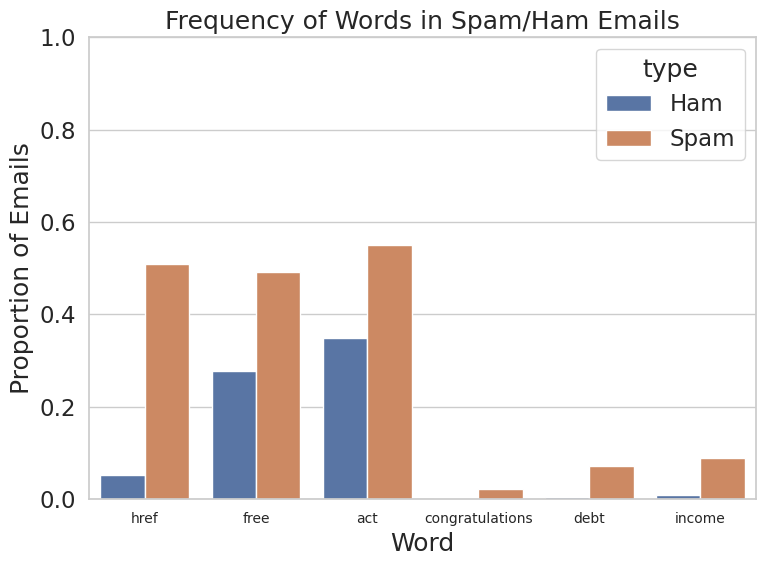

In [45]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts.
plt.figure(figsize=(8,6))
sns.barplot(data=spam_ham_df, x='variable', y='value', hue='type')

ax = plt.gca()
ax.set_ylim(0, 1)
ax.set_ylabel('Proportion of Emails')

ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xlabel('Word')

plt.title('Frequency of Words in Spam/Ham Emails')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Length Distribution of Ham and Spam Emails')

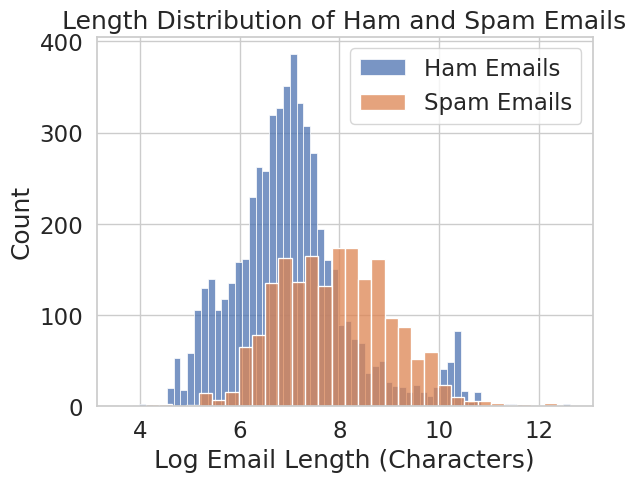

In [46]:
ham_email_lengths = train_ham_emails.str.len()
spam_email_lengths = train_spam_emails.str.len()

# ham_email_lengths.value_counts().sort_index()
# sns.histplot(ham_email_lengths.sort_values()[:-100], label='Ham Emails')
# sns.histplot(spam_email_lengths.sort_values()[:-20], label='Spam Emails')
sns.histplot(np.log(ham_email_lengths).sort_values(), label='Ham Emails')
sns.histplot(np.log(spam_email_lengths).sort_values(), label='Spam Emails')
plt.legend()
plt.xlabel('Log Email Length (Characters)')
plt.title('Length Distribution of Ham and Spam Emails')

In [47]:
train.head()

,id,subject,email,spam
0,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0
1,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0
2,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0
3,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0
4,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0


Text(0.5, 1.0, 'Length Distribution of Ham and Spam Subjects')

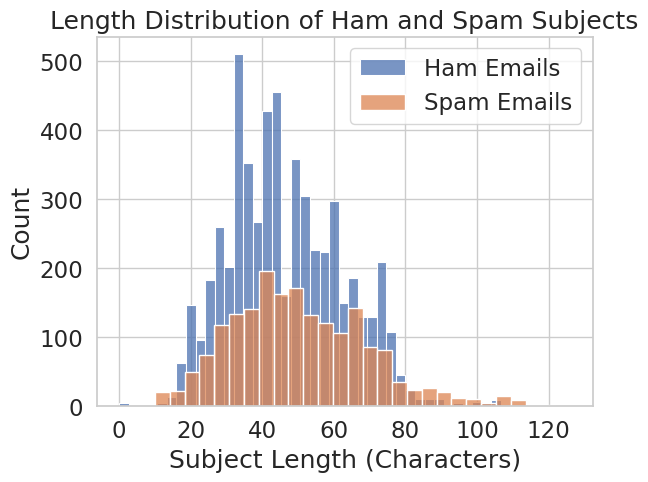

In [48]:
train_ham_subjects = train.loc[train['spam'] == 0, 'subject']
train_spam_subjects = train.loc[train['spam'] == 1, 'subject']

ham_subject_lengths = train_ham_subjects.str.len()
spam_subject_lengths = train_spam_subjects.str.len()

# ham_email_lengths.value_counts().sort_index()
# sns.histplot(ham_email_lengths.sort_values()[:-100], label='Ham Emails')
# sns.histplot(spam_email_lengths.sort_values()[:-20], label='Spam Emails')
sns.histplot(ham_subject_lengths.sort_values(), label='Ham Emails')
sns.histplot(spam_subject_lengths.sort_values(), label='Spam Emails')
plt.legend()
plt.xlabel('Subject Length (Characters)')
plt.title('Length Distribution of Ham and Spam Subjects')

In [49]:
def is_reply(series):
    replies = ['Re:', 're:']
    return np.any(words_in_texts(replies, series), axis=1)
    

array([False, False,  True, ..., False,  True,  True])

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0.5, 1.0, 'Distribution of Ham/Spam Emails that are Replies')

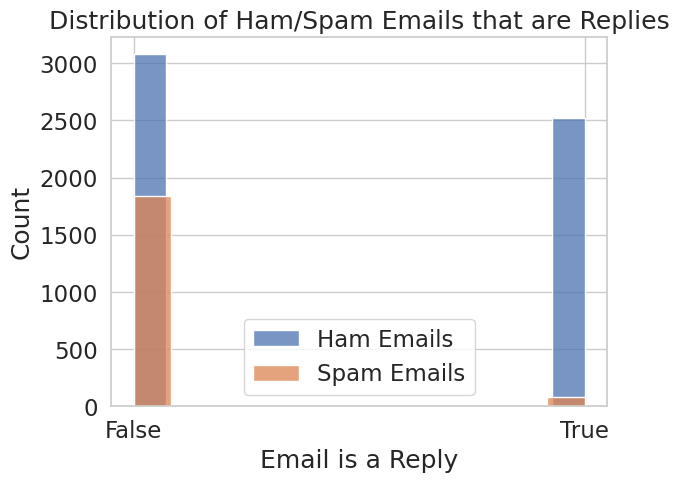

In [50]:
plt.clf()
ham_is_reply = is_reply(train_ham_subjects)
spam_is_reply = is_reply(train_spam_subjects)
display(ham_is_reply)

sns.histplot(ham_is_reply, label='Ham Emails')
sns.histplot(spam_is_reply, label='Spam Emails')
plt.legend()
plt.xlabel('Email is a Reply')
plt.xticks([0, 1], ['False', 'True'])
plt.title('Distribution of Ham/Spam Emails that are Replies')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 1b

In two to three sentences, describe what you plotted and its implications with respect to your features.

When plotting the distribution of email lengths of spam versus ham emails, it appears that the distribution is ever so slightly shifted rightwards for the spam emails versus the ham emails, suggesting that spam emails tend to be perhaps slightly larger in terms of length of characters compared to ham emails. When plotting the subject lengths, the distribution seems to be relatively similar. This perhaps indicates that both subject and email length may not be very indicative of ham or spam emails.

Interestingly, when plotting the distribution of Ham/Spam emails that are replies, we see a huge shift. The vast majority of spam emails are NOT replies, whereas a large proportion of Ham emails are! When compared to the differences in length distributions between the two samples, it appears clear from plotting that the "Is a Reply" feature has more of a clear distinction between spam and ham emails. Thus, I will prioritize including the "Is a Reply" feature in my model over length 

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Question 2: Building Your Own Model

Now that you've explored the data and relevant features through EDA, it's time to build your model! As mentioned earlier, you may use whatever method you prefer to create features, but **you may only use the packages we've imported for you in the cell below or earlier in this notebook**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc. 

Please consider the ideas mentioned above when choosing features. We have not provided any code to do this, so feel free to create as many cells as you need to tackle this task. 

In [51]:
# import libraries
# You may use any of these to create your features.
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import re
from collections import Counter

In [52]:
## Feature Functions

def is_reply(series):
    replies = ['Re:', 're:']
    return np.any(words_in_texts(replies, series), axis=1)
    

In [53]:
train

,id,subject,email,spam
0,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0
1,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0
2,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0
3,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0
4,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0
...,...,...,...,...
7508,5734,Subject: [Spambayes] understanding high false ...,">>>>> ""tp"" == tim peters <tim.one@comcast.net>...",0
7509,5191,Subject: Reach millions on the internet!!\n,"\n dear consumers, increase your business sale...",1
7510,5390,Subject: Facts about sex.\n,\n forwarded-by: flower\n \n did you know that...,0
7511,860,Subject: Re: Zoot apt/openssh & new DVD playin...,"on tue, oct 08, 2002 at 04:36:13pm +0200, matt...",0


In [54]:
# Define your processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!

def pipeline(df):
    """
    Params
        df (pd.DataFrame): Df of emails containing id, subject, email, spam columns
    Returns
        feature_vector (pd.DataFrame): Design matrix in np.array form
        labels (pd.Series): Corresponding labels (spam/ham) of the emails
    """
    
    spam_words = ['href', 'money', 'opportunity', 'please', 'free', 'act',
                  'congratulations', 'debt', 'income', 'sex']
    
    spam_words_in_body = words_in_texts(spam_words, df['email'])
    feature_vector = pd.DataFrame(spam_words_in_body, columns = spam_words)
    feature_vector['Reply'] = is_reply(df['subject'])

    if 'spam' in df.columns:
        labels = df['spam']
        assert(len(labels) == len(feature_vector))
    else:
        labels = []
    return feature_vector, labels

feature_vector, labels = pipeline(train)

display(feature_vector)
labels


,href,money,opportunity,please,free,act,congratulations,debt,income,sex,Reply
0,0,0,0,0,1,0,0,0,0,0,False
1,0,0,0,0,0,1,0,0,0,0,False
2,0,0,0,1,1,0,0,0,0,0,True
3,0,0,0,1,0,1,0,0,0,0,False
4,1,0,1,0,1,1,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...
7508,0,0,0,0,0,0,0,0,0,0,False
7509,0,1,0,1,1,1,0,0,0,0,False
7510,0,0,0,0,0,1,0,0,0,1,False
7511,0,0,0,0,0,0,0,0,0,0,True


0       0
1       0
2       0
3       0
4       0
       ..
7508    0
7509    1
7510    0
7511    0
7512    0
Name: spam, Length: 7513, dtype: int64

In [55]:
my_model = LogisticRegression(penalty='l1', solver='liblinear')
my_model = my_model.fit(feature_vector, labels)

In [56]:
pd.DataFrame(my_model.coef_, columns=feature_vector.columns)

,href,money,opportunity,please,free,act,congratulations,debt,income,sex,Reply
0,2.255452,0.753703,1.039349,1.447582,-0.051608,-0.270623,0.12985,1.412148,1.183613,1.467133,-2.286255


<br>

---

# Question 3

### Grading Scheme

Your grade for this question will be based on your model’s accuracy when making predictions on the training set and your model’s accuracy when making predictions on the test set. The tables below provide scoring guidelines. If your accuracy lies in a particular range, you will receive the number of points associated with that range.

**Important**: While your training accuracy can be checked at any time in this notebook, your test accuracy can only be checked by submitting your model’s predictions to Gradescope. **You will only be able to submit your test set predictions to Gradescope up to 4 times per day**. In the case that you are approved for an extension, you are granted 4 more submissions for each day the deadline has been extended. Plan ahead to make sure you have enough time to fine-tune your model! The thresholds are as follows:

Points | 5 | 3 | 1.5 | 0
--- | --- | --- | --- | ---
**Training** Accuracy | 85% and Above | \[80, 85) | \[70, 80) | Below 70%

Points | 10 | 6 | 3 | 0
--- | --- | --- | --- | ---
**Testing** Accuracy | 85% and Above | \[80, 85) | \[70, 80) | Below 70%


<br><br>

---

## Question 3a: Train Predictions
Assign your predictions for the class of each data point in the training set `train` to `train_predictions`.

In [57]:
train_features, train_labels = pipeline(train)
assert(np.all(train_labels.to_numpy() == train['spam'].to_numpy()))

train_predictions = my_model.predict(train_features)

# Print your training accuracy. 
training_accuracy = np.mean(train_predictions == train["spam"])
training_accuracy

0.861173965127113

In [58]:
grader.check("q3a")

q3a results: All test cases passed!

In [59]:
val_features, val_labels = pipeline(val)

val_predictions = my_model.predict(val_features)

# Print your validation accuracy. 
validation_accuracy = np.mean(val_predictions == val_labels)
validation_accuracy

0.8562874251497006

<br>

---

## Question 3b: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to the "Project B2 Test Set Predictions" assignment on Gradescope to get credit for this question.**

Assign your predictions for the class of each datapoint in the test set `test` to a 1-dimensional array called `test_predictions`. **Please make sure you save your predictions to `test_predictions`, as this is how part of your score for this question will be determined.**

**Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions.** For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use `scikit-learn`'s `.predict` method.

**Gradescope limits you to 4 submissions per day to meet the threshold.** If you are approved for an extension, you are granted 4 more submissions for each day the deadline has been extended.

The provided tests check that your predictions are in the correct format but are worth 0 points in the *Project B2 Coding assignment*. To evaluate your classifier accuracy, you must submit the CSV file to the *Project B2 Test Set Predictions* assignment.

In [60]:
print('Before imputation, test data:')
print(test.isnull().sum())
test = test.fillna('')
print('------------')
print('After imputation:')
print(test.isnull().sum())

Before imputation, test data:
id         0
subject    1
email      0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
dtype: int64


In [61]:
test_features, _ = pipeline(test)
# display(test_features)
# display(_)
test_predictions = my_model.predict(test_features)

In [62]:
grader.check("q3b")

q3b results: All test cases passed!

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project B2 Test Set Predictions" assignment on Gradescope to get credit for this question.** You can only submit to Gradescope a maximum of 4 times per day, so please use your submissions wisely!

In [63]:
# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

Created a CSV file: submission_20240427_021853.csv.


You may now upload this CSV file to Gradescope for scoring.


<br/>
<hr style="border: 1px solid #fdb515;" />

# Analyzing Your Model

Congratulations on completing your model! In the next few questions, we'll ask you to comment on your process for building a successful model and better understand the amount of misclassifications your model makes. 

<!-- BEGIN QUESTION -->

<br>

---

# Question 4

Describe the process of improving your model. You should use at least 2-3 sentences each to address the following questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

1. I found new feature mainly through EDA, plotting various features and seeing if their distributions varied between the spam and ham emails. For example, plotting the distribution of certain words and seeing if they had different proportions of appearances between spam and ham emails allowed me to determine if  I should include those words in my word list to pass into the words_in_texts feature function. Conversely, when I plotted the distribution of spam/ham emails that are replies (found by finding if the subject line contains Re: or re:), I saw a very large difference between the two samples. Thus, I followed this logic and EDA to determine features that are more closely correlated with spam/ham emails for my model.

2. I tried performing a simple count of all characters in the subject / email body, giving a rough estimate of email length. However, when first plotting these features, there are a few outliers in both spam/ham emails where the email is extremely long, skewing the data to have a long right-tail (right-skewed). Thus I tried performing a log transformation on email body length, in number of characters, and feeding that into the model. However, when checking the coefficients of my logistic regression model, the absolute value of the weight corresponding to email body length was close to 0, meaning the feature was very minorly impactful on classifying spam/ham if it was helpful at all. Thus, the length of emails didn't seem to work as a feature. Conversely, the "Reply" feature seemed to work very well, having a strongly negative weight of greater than 2, meaning it was quite impactful on determining if an email was spam or ham.

3. It was surprising that length of the body of the email doesn't really correlate strongly with spam or ham emails; I would've thought that spam emails may be longer as they contain hyperlinks or other random garbage, but it looks like quite a few ham emails are also very long. Additionally, it was surprising that certain words which don't appear super frequently in the total population of emails, such as "Debt" or "Income", still have a relatively high weights in our model. This means that, although these words don't appear very frequently in the whole sample, when they do appear, they are usually quite indicative of the email being spam.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

# Question 5: ROC Curve

In most cases, we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late. In contrast, a patient can receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a particular class. To classify an example, we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, **we can adjust that cutoff threshold**. We can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The Receiver Operating Characteristic (ROC) curve shows this trade-off for each possible cutoff probability. In the cell below, plot an ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data. [Lecture 23](https://ds100.org/sp24/lecture/lec23/) may be helpful.

**Hint**: You'll want to use the `.predict_proba` method [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) for your classifier instead of `.predict` to get probabilities instead of binary predictions.

In [67]:
def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)
    
def tpr_threshold(X, Y, T): # Same as recall
    Y_hat = predict_threshold(my_model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def fpr_threshold(X, Y, T):
    Y_hat = predict_threshold(my_model, X, T)
    return np.sum((Y_hat == 1) & (Y == 0)) / np.sum(Y == 0)

thresholds = np.linspace(0, 1, 100)
tprs = [tpr_threshold(train_features, train_labels, t) for t in thresholds]
fprs = [fpr_threshold(train_features, train_labels, t) for t in thresholds]

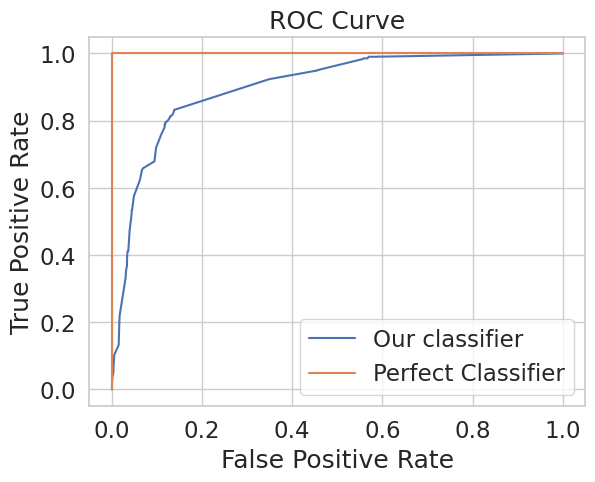

In [68]:
plt.plot(fprs, tprs, label="Our classifier")
plt.plot([0, 0, 1], [0, 1, 1], label="Perfect Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend();

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Diving Deeper

So far, we’ve been looking at our model through the lens of accuracy. In the next two questions, we'll dive deeper into the complexities of analyzing our model's performance. In particular, we'll ask you to explore some ambiguous cases that can arise, even within the training data itself, and the consequences of misclassification. You may have already come across some of these cases unknowingly when building your model!

<br><br>

---

## Question 6

To help you better understand some of the challenges that arise with classification, we've selected three emails from the `train` `DataFrame` and provided them below. Each email highlights a different issue that could arise. Skim through each of the emails below before answering part a).

### Example 1

In [69]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[5216]["spam"]))
print("\nemail:\n" + train.loc[5216]["email"])

spam: 1

email:
hello you two,
 
 i am so sorry catherine for not writing recently. i have just been vv busybeing a working mother and sometimes it all gets too much you know!! i cannot wait to see you both although we may meet at the airport on the 16/6 as that's the day we're going to france but i will see you both at bronagh's house for her 30th which we're going to on the way back from the airport. i am so excited about seeing you!!! liitle eva ( aine) was born on tuesday
  she is absolutely incredible. poor bronagh is 11 dsays over!!
 sounds like you've been having an amazing time. hope you won't be too depressed to be back!!
 
 lots of love
 
 deirdre
 "justin mason" <jm@jmason.org> wrote:
 
 <  
 <  just a quick note -
 <  
 <  we've decided to go up to annapurna base camp instead of
 <  the jomsom trek - it's a bit more impressive visually
 <  (if a little soggier).   so as of tomorrow morning, ourselves
 <  and our guide bhadra will be leaping like gazelles up 4000-odd
 <  met

### Example 2

In [70]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[36]["spam"]))
print("\nemail:\n" + train.loc[36]["email"])

spam: 0

email:
lifetime movie newsletter
 
 this week's movies to watch on lifetime
 
 [ http://www.lifetimetv.com/movies/index.html ]
 
 august 19, 2002
 
 *************************************************************************
 
 coming at you this week...
 
 1) "the secret life of zoey" premiere!
 2) the buzz about the upcoming movie
 3) movies airing this week
 4) big event: a martinez sunday
 5) fun and games
 
 *************************************************************************
 
 "the secret life of zoey" premiere!
 
 take a sneak peek at lifetimes next exciting original movie, "the secret life of zoey" [ http://www.lifetimetv.com/movies/info/move3195.html ], airing on monday, august 19 at 9 pm et/pt. zoey's mom thought she knew everything about her perfect teenage daughter. but when she realizes that her child is addicted to drugs, both of their worlds spin out of control. this dramatic film delves into the topic of teenage drug addiction and features stellar performer

### Example 3

In [71]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[1092]["spam"]))
print("\nemail:\n" + train.loc[1092]["email"])

spam: 0

email:
this is a multi part message in mime format.
 
 --_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv
 content-type: text/plain; charset="us-ascii"
 content-transfer-encoding: 7bit
 
 ........... with our telecoms partner bumblebee !
 
 don't get ripped off by expensive hotel, payphone and mobile charges. 
 save, save, save on international calls with ryanair's phone partner. 
 ************************************************************************
 *********
 
 you'll save up to 70% on international phone calls when you use our 
 online phone card.  you can use the card from any phone in any country 
 you visit and you won't have to worry about high phone charges 
 when you call home or the office.
 
 buying a card couldn't be easier and it's totally secure.  simply go to
 http://www.bumblebeecommunications.com/lowcostcalls/  
  to avail of this special offer for ryanair customers.
 
 it's another great deal from ryanair and our online phone 
 partner, bumblebee communications. 


<!-- BEGIN QUESTION -->

### Question 6a

Pick at least **one** of the emails provided above to comment on. How would you classify the email (e.g., spam or ham), and does this align with the classification provided in the training data? What could be a reason someone would disagree with *your* classification of the email? In 2-3 sentences, explain your perspective and potential reasons for disagreement.

For example 1, the email is classified as spam in the training data, but I personally believe that it is a regular, non-spam email. The reason I believe this email is not a spam email is because the body of the email seems to be genuinely written by an individual who wants to connect with her family or loved ones, and it contains some reasonable spelling errors that are human-like. However, someone may disagree with this classification because the email is sent as a reply, and contains the original email being replied to in the body of the text. In this original email, there are the words "travelogue mailing list," presumably from the person's signature (perhaps he sent a personal email from his business email or something). Thus, the signature may seem like the email is a spam email, but when reading the actual context of the emails, it appears to me that the email is not spam.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

As data scientists, we sometimes take the data to be a fixed “ground truth,” establishing the “correct” classification of emails. However, as you might have seen above, some emails can be ambiguous; people may disagree about whether an email is actually spam or ham. How does the ambiguity in our labeled data (spam or ham) affect our understanding of the model's predictions and the way we measure/evaluate our model's performance?

Obviously, if the definition of what spam or ham emails are is subjective, this changes how we evaluate our model performance because the data and labels we train on may not necessarily be "accurate," or we may have to start questioning the ground truth of our training data. Thus, it becomes more difficult to just trust accuracy of our model in predicting labels because the training labels may not be accurate themselves. Additionally, this may make it more difficult to generalize our model; if we were to generalize it, it would need to be used on data that was acquired with the exact same criteria and labeling rationale as this original training data, to try and account for the subjectivity of spam/ham emails from different people.

<!-- END QUESTION -->

As a data scientist, we encourage you to think more critically about your data before establishing it as the "ground truth." Whenever you're working on a specific problem, ask yourself:  
1. Who “made” the data? Think about all the stages from when it was first generated, collected, and labeled before it ended up in a CSV file.
2. What assumptions and biases are inherently present in the data?
3. And finally, how does all this affect how you interpret your model’s performance?

<br><br>

---

## Question 7

In Question 6, we explored the instability present in the “ground truth” and how this affects our evaluation of our model. Now, let's start thinking about your model's interpretability and what that means more broadly for an email classification task. A model is considered interpretable if humans can easily understand the reasoning behind its predictions and classifications.

### Question 7a

First, let's see if we can understand how our choice of features relates to how a particular email is classified. 

#### Part i

Let’s take a look at the `simple_model` we provided you earlier that uses 5 features. We have provided the code below for ease of reference. You will examine how a particular feature influences how an email is classified. 

In [72]:
# Simple model introduced at the start of this notebook. Just pay attention to the features.
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train);

In [73]:
pd.DataFrame(simple_model.coef_, columns=some_words)

,drug,bank,prescription,memo,private
0,0.387679,1.413033,2.044377,-0.536767,0.923349


Pick an email from the training set and assign its index to `email_idx`. Then, find **one** feature used in `simple_model` such that **removing** it changes how that email is classified. Assign this feature to  `feature_to_remove`.

In [74]:
# Use this cell for scratch work when determining `email_idx`
has_some_words = train['email'][np.any(words_in_texts(some_words, train['email']), axis=1)]
display(has_some_words)
words_in_texts(some_words, has_some_words)

4       <html>\n <head>\n <title>tech update today</ti...
8       url: http://www.newsisfree.com/click/-0,861367...
19      <html>\n <head>\n </head>\n <center>\n <h1>\n ...
27      dear opportunities seekers:\n \n i thought you...
32      <html><body onload="window.open('http://202.10...
                              ...                        
7462    <html>\n <head>\n <title>cnet investor dispatc...
7477    \n the internet's online pharmacy\n \n viagra ...
7492     \n sent e-mail message   \n  \n from: enenkio...
7507    \n mr. ayanda maredi\n department of minerals ...
7509    \n dear consumers, increase your business sale...
Name: email, Length: 919, dtype: object

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 1, 0, 1],
       ...,
       [1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [75]:
email_idx = 7509

prob_spam = simple_model.predict_proba(X_train)[:, 1]
initial_prob = prob_spam[email_idx]
initial_class = "spam" if np.round(initial_prob) else "ham"
print(f"\nPredicted probability of being spam: {np.round(initial_prob*100, 2)}%")
print("\nEmail:\n" + train.loc[email_idx]["email"])


Predicted probability of being spam: 55.57%

Email:

 dear consumers, increase your business sales!  how?? by 
 targeting millions of buyers via e-mail !! 
 15 million emails  + bulk mailing software for only $100.00
                             super low price! act now !!!
                      
 our fresh addresses will bring you 
 incredible results!
 
 
 if you really want to get the word out regarding
 your services or products, bulk email is the best 
 way to do so, period! advertising in newsgroups is 
 good but you're competing with hundreds even thousands
 of other ads. will your customer's see your ad in the 
 midst of all the others?
 
 free classifieds?  (don't work)
 web site?          (takes thousands of visitors)
 banners?           (expensive and iffy)
 e-zine?            (they better have a huge list)
 search engines?    (easily buried with thousands of others)
 
 bulk email will allow you to directly contact your
 potential customers. they are much more likely to
 ta

In [76]:
feature_to_remove = 'bank'

changed_words = some_words.copy()
changed_words.remove(feature_to_remove)

changed_model = LogisticRegression()
X_changed = words_in_texts(changed_words, train['email'])
y = train['spam']
changed_model.fit(X_changed, y)
changed_prob = changed_model.predict_proba(X_changed[[email_idx]])[:,1][0]
changed_class = "spam" if np.round(changed_prob) else "ham"

print(f"Initially classified as {initial_class} (Probability: {np.round(initial_prob*100, 2)}%)")
print(f"Now classified as {changed_class} (Probability: {np.round(changed_prob*100, 2)}%)")

Initially classified as spam (Probability: 55.57%)
Now classified as ham (Probability: 24.33%)


In [77]:
grader.check("q7ai")

q7ai results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Part ii

In 2-3 sentences, explain why you think the feature you chose to remove changed how your email was classified.

I chose an email that didn't contain any of the other words in the some_words list, but only contained the word 'bank'. Therefore, by removing the word 'bank' from the some_words list, and thus removing it as a feature, the model no longer had that variable to distinguish the email as spam. Additionally, because the weight corresponding to the 'bank' word feature is relatively high (1.413033), removing this feature has a relatively high impact on the model prediction.

<!-- END QUESTION -->

### Question 7b

Now, let's say that instead of working with a small model containing 50-100 features, you're working with a much larger, more accurate model containing 1000 features. 

<!-- BEGIN QUESTION -->

#### Part i
In this context, do you think you could easily find a feature that could change an email's classification as you did in part a)? Why or why not?

No I don't believe so. This is because, with a model with many more features, the removal of one single feature is less likely to make a significant impact on the prediction. Especially with regularization techniques in place, a model with multiple features is more likely to have weights of smaller values, meaning each individual feature matters less to the overall prediction. Therefore, it would be very difficult to find a single feature to delete that would be weighted so heavily that it could change an email's classification.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part ii 
Would you expect this new model to be more or less interpretable than `simple_model`?

**Note**: A model is considered interpretable if you can easily understand the reasoning behind its predictions and classifications. For example, the model we saw in part a), `simple_model`, is considered interpretable as we can identify which features contribute to an email's classification.

This model would be less interpretable than the simple model because there are significantly more features. It would become less clear which features are extremely important for the model, and which features are less important individually and only contribute holistically to the model. The more features there are, the less interpretable the model will become because it is difficult to understand what exactly each feature is contributing.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7c

Now, imagine you’re a data scientist at Meta, developing a text classification model to decide whether to remove certain posts / comments on Facebook. In particular, you’re primarily working on moderating the following categories of content:
* Hate speech
* Misinformation 
* Violence and incitement

Pick one of these types of content to focus on (or if you have another type you’d like to focus on, feel free to comment on that!). What content would fall under the category you’ve chosen? Refer to Facebook’s [Community Standards](https://transparency.fb.com/policies/community-standards/), which outline what is and isn’t allowed on Facebook. 

If I were to focus on Hate Speech, the type of content that would fall under this category would include any pointed posts or videos that encourage hatred and violence against a specific group of people, solely based on their religion, race, sex, etc. This kind of content would not be allowed under the Community Standards, as not only does it violate the dignity of individuals within the targeted group, but also threatens the safety of members of that group. Social media that encourages hatred towards a particular group could have long-standing and widespread social consequences; for example, increased random acts of violence against Asian people after increased hate speech against China occurred due to the outbreak of coronavirus. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7d

What are the stakes of misclassifying a post in the context of a social media platform? Comment on what a false positive or false negative means for the category of content you’ve chosen (hate speech, misinformation, or violence and incitement).

The mistake of misclassifying a post could lead to an infringement of people's voices, and an infringment of the "authenticity" of Facebook. Overzealous removal of posts could almost be akin to censorship, where any quote on quote "negative posts" could just be removed, leading to a deafening of a voices for a certain group of people with the same ideology. There is a fine balance between allowing people to excercise their right to their own opinion and voice, while also maintaining public safety and ensuring those voices aren't being used to encourage violence against another group. A False Positive for hate speech would be someone mentioning a particular gender, race, religion, or group of people in their post but not saying anything hateful at all, just simply mentioning them in their post, but being flagged for hate speech. Another good, relevant example for today's political climate would be posts referencing "Free Palestine," which obviously refer to Palestinians but if falsely classified as hate speech would be removed and thus remove a good number of voices supporting Palestine and ceasefire. A false negative for hate speech would be a post that is overtly racist or hateful towards a group, but isn't detected by the model. An example could be a post referencing a racial slur, or insinuating hatred against a group of people in more subtle terms, but not overtly typing any race or group of people in the post.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7e

As a data scientist, why might having an interpretable model be useful when moderating content online?

An interpretable model may be more useful for moderating content because it is easier to understand how to fine-tune the model to better detect hate speech, or reduce False Positives and reduce False Negatives. For example, if features are simpler such as simple words, one can always add another feature corresponding to a new hate word that the model can detect. If the model is more complex and less interpretable, it becomes difficult to perform fine-tuning of the model.

<!-- END QUESTION -->

As you explored throughout this question, interpretability is incredibly important. However, it is equally important to note that interpretability on its own isn’t a fix to all the problems that may arise when moderating content or when building a model more generally. As we touched on in Project A2, these models don’t operate in a vacuum; they exist in a wider sociotechnical system. Everything from the data used to train these models to the metrics we choose to evaluate our models builds on that notion.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Mimi and Trouble congratulate you for finishing Project B2!

<div align="middle">
    <table style="width:75%">
      <tr align="center">
        <td><video controls src = "images/mimi.mp4" width = "250">animation</video>
        <td><img src="images/trouble2.jpeg" align="middle" width="325vw"/>
        <td><img src="images/trouble.jpeg" align="middle" width="325vw"/>
      </tr>
    </table>
  </div>

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/e/1FAIpQLSe0fBEJwt6aEfZxU3fh3llNk8rSWHj6Umq0km3wPqmFu0MlGA/viewform). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Once you submit this file to the Project B2 Coding assignment on Gradescope, Gradescope will automatically submit a PDF file with your written answers to the Project B2 Written assignment. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

If there are issues with automatically generating the PDF, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. 

**Please make sure you submit the following to the right assignments:**

* **Project B2 Coding:** Submit the zip file generated by using the `grader.export()` cell provided below.
* **Project B2 Written:** Gradescope will automatically submit the PDF from the zip file submitted earlier. You do not need to submit anything to this assignment yourself, but *please check that the submission went through properly and that all plots rendered correctly*.
* **Project B2 Test Set Predictions:** Submit the CSV file generated in `q3b`.

**You are responsible for ensuring your submission follows our requirements and that everything was generated and submitted correctly. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [78]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q3a results: All test cases passed!

    q3b results: All test cases passed!

    q7ai results: All test cases passed!
